## Fake News Detection using Bidirectional LSTM
Dataset - https://onlineacademiccommunity.uvic.ca/isot/2022/11/27/fake-news-detection-datasets/
</br>

### Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, GlobalMaxPooling1D, Dense
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, classification_report
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

2025-06-19 04:26:05.579146: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750307166.077827      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750307166.189940      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


### Reading Dataset

In [2]:
true_data = pd.read_csv('/kaggle/input/fakenews/True.csv')
true_data.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [3]:
false_data = pd.read_csv('/kaggle/input/fakenews/Fake.csv')
false_data.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [4]:
print("Number of true news articles: ", len(true_data))
print("Number of false news articles: ", len(false_data))

Number of true news articles:  21417
Number of false news articles:  23481


### Concatenating both Datasets

In [5]:
true_data['label'] = 1
false_data['label'] = 0


In [6]:
data = pd.concat([true_data, false_data], ignore_index=True)
data['content'] = data['title'] + ' ' + data['text']
data = data[['content', 'label']]
data = data.sample(frac=1).reset_index(drop=True)
data.head()

,content,label
0,"WOW! STERLING HTS, MI CITY COUNCIL Caves On Me...",0
1,CLASS ACT: Watch Betsy DeVos Respond While Stu...,0
2,What's behind Vietnam's corruption crackdown? ...,1
3,German voters punish FDP leader for coalition ...,1
4,President Trump Travels to Orlando for Private...,0


In [7]:
print("Total number of entries: ", len(data))
print("Number of fake news articles: ", len(data[data['label'] == 0]))
print("Number of true news articles: ", len(data[data['label'] == 1]))

Total number of entries:  44898
Number of fake news articles:  23481
Number of true news articles:  21417


### Data Preprocessing

In [8]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [9]:
def clean_text(text):
    text = text.lower()                              # Lowercase
    text = re.sub(r'[^\w\s]', '', text)              # Remove punctuation
    text = re.sub(r'[^a-z\s]', '', text)             # Remove non-alphabetic characters
    tokens = text.split()                            # Tokenize by space
    tokens = [word for word in tokens if word not in stop_words]  # Remove stopwords
    return ' '.join(tokens)

data['cleaned_content'] = data['content'].apply(clean_text)

In [10]:
max_words = 1000
max_len = 1000

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(data['cleaned_content'])
sequences = tokenizer.texts_to_sequences(data['cleaned_content'])
X = pad_sequences(sequences, maxlen=max_len)

### Train-Test-Valid Split

In [11]:
X_train, X_temp, y_train, y_temp = train_test_split(X, data['label'], test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print("Train:", X_train.shape)
print("Validation:", X_val.shape)
print("Test:", X_test.shape)

Train: (31428, 1000)
Validation: (6735, 1000)
Test: (6735, 1000)


### Bidirectional LSTM Model

In [12]:
input_layer = Input(shape=(max_len,))
embedding_layer = Embedding(input_dim=max_words, output_dim=300, input_length=max_len)(input_layer)
bilstm_layer = Bidirectional(LSTM(128, return_sequences=True))(embedding_layer)
pooling_layer = GlobalMaxPooling1D()(bilstm_layer)
dense_1 = Dense(128, activation='relu')(pooling_layer)
output_layer = Dense(1, activation='sigmoid')(dense_1)

model = Model(inputs=input_layer, outputs=output_layer)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
I0000 00:00:1750307205.540150      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1750307205.540923      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [13]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 1000)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding (Embedding)                │ (None, 1000, 300)           │         300,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 1000, 256)           │         439,296 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d                 │ (None, 256)                 │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 772,321 (2.95 MB)

 Trainable params: 772,321 (2.95 MB)

 Non-trainable params: 0 (0.00 B)

### Training

In [14]:
model.fit(X_train, y_train, epochs=5, batch_size=2, validation_data=(X_val, y_val))

Epoch 1/5


I0000 00:00:1750307212.054182      96 cuda_dnn.cc:529] Loaded cuDNN version 90300


15714/15714 ━━━━━━━━━━━━━━━━━━━━ 991s 63ms/step - accuracy: 0.9841 - loss: 0.0378 - val_accuracy: 0.9985 - val_loss: 0.0067
Epoch 2/5
15714/15714 ━━━━━━━━━━━━━━━━━━━━ 985s 63ms/step - accuracy: 0.9987 - loss: 0.0055 - val_accuracy: 0.9991 - val_loss: 0.0042
Epoch 3/5
15714/15714 ━━━━━━━━━━━━━━━━━━━━ 984s 63ms/step - accuracy: 0.9991 - loss: 0.0032 - val_accuracy: 0.9991 - val_loss: 0.0063
Epoch 4/5
15714/15714 ━━━━━━━━━━━━━━━━━━━━ 983s 63ms/step - accuracy: 0.9996 - loss: 0.0019 - val_accuracy: 0.9979 - val_loss: 0.0141
Epoch 5/5
15714/15714 ━━━━━━━━━━━━━━━━━━━━ 983s 63ms/step - accuracy: 0.9997 - loss: 8.4202e-04 - val_accuracy: 0.9987 - val_loss: 0.0152


### Saving the model

In [20]:
import pickle
from tensorflow.keras.models import save_model

# Save tokenizer
with open("tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)

# Save model
model.save("fake_news_model.h5")


### Results

In [16]:
y_probs = model.predict(X_test)  # Probabilities
y_pred = (y_probs > 0.5).astype("int32")  # Threshold at 0.5

211/211 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step


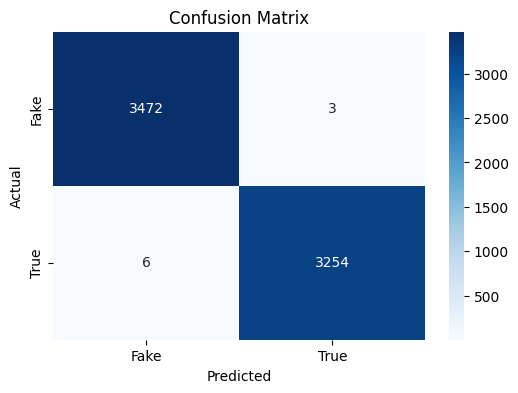

In [17]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Fake", "True"], yticklabels=["Fake", "True"])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [18]:
# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# AUC
auc = roc_auc_score(y_test, y_probs)
print(f"AUC: {auc:.4f}")

# Precision
precision = precision_score(y_test, y_pred)
print(f"Precision: {precision:.4f}")

# Recall
recall = recall_score(y_test, y_pred)
print(f"Recall: {recall:.4f}")

# F1 Score
f1 = f1_score(y_test, y_pred)
print(f"F1 Score: {f1:.4f}")

# Step 5: EER (Equal Error Rate)
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
fnr = 1 - tpr
eer_threshold = thresholds[np.nanargmin(np.absolute((fnr - fpr)))]
eer = fpr[np.nanargmin(np.absolute((fnr - fpr)))]
print(f"EER: {eer:.4f} at threshold = {eer_threshold:.4f}")

Accuracy: 0.9987
AUC: 1.0000
Precision: 0.9991
Recall: 0.9982
F1 Score: 0.9986
EER: 0.0012 at threshold = 0.0160


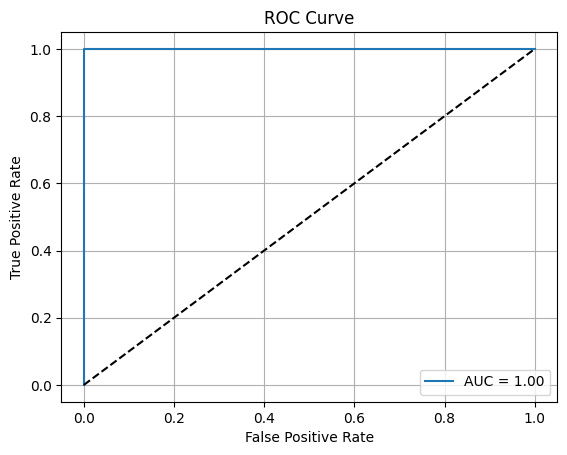

In [19]:
plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.show()